In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
!pip install -q evaluate transformers==4.33.1
!pip install -U -q datasets
!pip install -q torchaudio==0.12.0+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html
!add-apt-repository -y ppa:savoury1/ffmpeg4
!apt-get -qq install -y ffmpeg
!pip install -q mlflow
!pip install -q SpeechRecognition

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pytorch-lightning 2.4.0 requires torch>=2.1.0, but you have torch 1.12.0+cu113 which is incompatible.
stable-baselines3 2.1.0 requires torch>=1.13, but you have torch 1.12.0+cu113 which is incompatible.
Repository: 'deb https://ppa.launchpadcontent.net/savoury1/ffmpeg4/ubuntu/ jammy main'
Description:
FFmpeg 4.4.5 builds (& associated multimedia packages) for Xenial & newer.

*** Anyone interested in full builds of FFmpeg 4.4.x including all "bells and whistles" needs to have donated, after which access to the new private PPA can be requested. See my Launchpad page linked below for details. ***

*** Please always see https://launchpad.net/~savoury1 for general updates about this Launchpad site before contacting me or reporting any bugs! ***

*** Big thanks to all those who have donated to support this project, you

In [ ]:
import pandas as pd
import gc
import re
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm
from pathlib import Path
import torch
import transformers
import torchaudio
import evaluate
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, classification_report, roc_auc_score
import matplotlib.pyplot as plt
import itertools
from transformers import AutoFeatureExtractor, AutoModelForAudioClassification, pipeline, TrainingArguments, Trainer
from datasets import Dataset, ClassLabel
from imblearn.under_sampling import RandomUnderSampler

In [ ]:
import torchaudio

In [ ]:
df0 = pd.read_csv('/kaggle/input/common-voice/cv-valid-train.csv', usecols=['filename', 'accent', 'gender'])
df1 = pd.read_csv('/kaggle/input/common-voice/cv-valid-dev.csv', usecols=['filename', 'accent', 'gender'])
df2 = pd.read_csv('/kaggle/input/common-voice/cv-valid-test.csv', usecols=['filename', 'accent', 'gender'])
dd = pd.concat([df0, df1, df2], axis=0)
dd = dd[~dd['accent'].isnull() & ~dd['gender'].isnull()].drop_duplicates()
print(dd.shape)
dd.sample(5).T

(66416, 3)


,35361,182568,68788,1386,125835
filename,cv-valid-train/sample-035361.mp3,cv-valid-train/sample-182568.mp3,cv-valid-train/sample-068788.mp3,cv-valid-train/sample-001386.mp3,cv-valid-train/sample-125835.mp3
gender,male,male,female,male,male
accent,england,england,us,us,canada


## Loading the data

In [ ]:
def load_data():
    file_list = []
    full_list = []
    for file in tqdm(Path('/kaggle/input/common-voice/').glob('cv-valid-*/*/*.mp3')):
        full_path = str(file)
        file_name = '/'.join(str(file).split('/')[-2:])
        file_list.append(file_name)
        full_list.append(full_path)
    df = pd.DataFrame()
    df['filename'] = file_list
    df['file'] = full_list
    return df

df = load_data()
df = df.merge(dd, on='filename', how='inner')
df.rename(columns={'accent': 'label_accent', 'gender': 'label_gender'}, inplace=True)

203847it [00:12, 16532.79it/s] 


In [ ]:
from imblearn.under_sampling import RandomUnderSampler
import gc

y_accent = df[['label_accent']]
y_gender = df[['label_gender']]
df = df.drop(['label_accent', 'label_gender'], axis=1)
rus = RandomUnderSampler(random_state=83, sampling_strategy='majority')
df_accent_resampled, y_accent_resampled = rus.fit_resample(df, y_accent)
df_gender_resampled, y_gender_resampled = rus.fit_resample(df, y_gender)
df_accent_resampled.reset_index(drop=True, inplace=True)
df_gender_resampled.reset_index(drop=True, inplace=True)
y_accent_resampled.reset_index(drop=True, inplace=True)
y_gender_resampled.reset_index(drop=True, inplace=True)
df_accent_resampled['label_accent'] = y_accent_resampled
df_gender_resampled['label_gender'] = y_gender_resampled
df_resampled = pd.merge(df_accent_resampled, df_gender_resampled, how='inner', on=df.columns.tolist())
del y_accent, y_gender, df_accent_resampled, df_gender_resampled
gc.collect()

30

## Splitting the audio into segments for accent

In [ ]:
MAX_LENGTH = 16000
RATE_HZ = 16000
def split_audio(file):
    try:
        audio, rate = torchaudio.load(str(file))
        num_segments = (len(audio[0]) // MAX_LENGTH)
        segmented_audio = []
        for i in range(num_segments):
            start = i * MAX_LENGTH
            end = min((i + 1) * MAX_LENGTH, len(audio[0]))
            segment = audio[0][start:end]
            segment = torchaudio.transforms.Resample(rate, RATE_HZ)(segment).squeeze(0).numpy().reshape(-1)
            segmented_audio.append(segment)
        return pd.DataFrame({'audio': segmented_audio})
    except Exception as e:
        print(f"Error processing file: {e}")
        return None

df_list = []
for input_file, input_label in tqdm(zip(df_resampled['file'].values, df_resampled['label_accent'].values)):
    resulting_df = split_audio(input_file)
    if resulting_df is not None:
        resulting_df['label'] = input_label
        df_list.append(resulting_df)

10058it [05:18, 31.59it/s]


In [ ]:
df = pd.concat(df_list, axis=0)
gc.collect()

0

## Computing the class weights

In [ ]:
classes = np.unique(df['label'])
weights = compute_class_weight(class_weight='balanced', classes=classes, y=df['label'])
class_weights = dict(zip(classes, weights))

## Preparing the final dataset

In [ ]:
dataset = Dataset.from_pandas(df)
labels_list = sorted(list(df['label'].unique()))
label2id, id2label = {label: i for i, label in enumerate(labels_list)}, {i: label for i, label in enumerate(labels_list)}
ClassLabels = ClassLabel(num_classes=len(labels_list), names=labels_list)

## Mapping the dataset with the corresponding labels

In [ ]:
def map_label2id(example):
    example['label'] = ClassLabels.str2int(example['label'])
    return example

In [ ]:
dataset = dataset.map(map_label2id, batched=True)
dataset = dataset.cast_column('label', ClassLabels)
dataset = dataset.train_test_split(test_size=0.2, shuffle=True, stratify_by_column="label")  # Adjust TEST_SIZE as needed

Map:   0%|          | 0/122389 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/122389 [00:00<?, ? examples/s]

## Creating the Wav2Vec2-base model

In [ ]:
model_str = "facebook/wav2vec2-base-960h"
feature_extractor = AutoFeatureExtractor.from_pretrained(model_str)
model = AutoModelForAudioClassification.from_pretrained(model_str, num_labels=len(labels_list))
model.config.id2label = id2label

preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.60k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed', 'classifier.weight', 'classifier.bias', 'projector.weight', 'projector.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def preprocess_function(batch):
    inputs = feature_extractor(batch['audio'], sampling_rate=RATE_HZ, max_length=MAX_LENGTH, truncation=True)
    inputs['input_values'] = inputs['input_values'][0]
    return inputs

In [ ]:
dataset['train'] = dataset['train'].map(preprocess_function, remove_columns="audio", batched=False)
dataset['test'] = dataset['test'].map(preprocess_function, remove_columns="audio", batched=False)
gc.collect()

Map:   0%|          | 0/97911 [00:00<?, ? examples/s]

Map:   0%|          | 0/24478 [00:00<?, ? examples/s]

92

## Evaluation metrics - ROC-AUC score and Accuracy

In [ ]:
import evaluate
accuracy_metric = evaluate.load("accuracy")
roc_auc_metric = evaluate.load("roc_auc")

In [ ]:
import numpy as np
from sklearn.metrics import roc_auc_score
import evaluate

def compute_metrics(eval_pred):
    logits, label_ids = eval_pred.predictions, eval_pred.label_ids
    probabilities = np.exp(logits) / np.exp(logits).sum(axis=1, keepdims=True)
    roc_auc = roc_auc_score(label_ids, probabilities, average='macro', multi_class='ovr')
    acc_score = accuracy_metric.compute(predictions=probabilities.argmax(axis=1), references=label_ids)['accuracy']
    return {"roc_auc": roc_auc, "accuracy": acc_score}

## Setting the model training parameters

In [ ]:
from transformers import AdamW

In [ ]:
from transformers import Trainer, TrainingArguments, Adafactor, get_scheduler

training_args = TrainingArguments(
    output_dir=model_str,
    num_train_epochs=12,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    evaluation_strategy='epoch',
    save_strategy='epoch',
    learning_rate=1e-5,
    weight_decay=0.01,
    warmup_steps=50,
    logging_dir='./logs',
    logging_steps=10,
    report_to="mlflow",
    fp16=True,
    lr_scheduler_type="cosine"
)

optimizer = Adafactor(
    model.parameters(),
    lr=1e-5,
    scale_parameter=False,
    relative_step=False
)

scheduler = get_scheduler("cosine", optimizer, num_warmup_steps=50, num_training_steps=122390)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
    compute_metrics=compute_metrics,
    optimizers=(optimizer, scheduler)
)

In [ ]:
trainer.evaluate()

{'eval_loss': 2.690138101577759,
 'eval_roc_auc': 0.5193773879744167,
 'eval_accuracy': 0.15663044366369802,
 'eval_runtime': 168.3988,
 'eval_samples_per_second': 145.357,
 'eval_steps_per_second': 36.342}

## Training the model

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Roc Auc,Accuracy
1,1.549300,1.676684,0.657252,0.448484
2,1.749600,1.495970,0.718890,0.535052
3,1.494700,1.525840,0.731239,0.556581
4,1.532200,1.457720,0.765256,0.574067
5,1.634800,1.531942,0.760985,0.575823
6,1.318400,1.506347,0.758336,0.576885
7,1.490500,1.439712,0.770117,0.583790
8,1.093400,1.618371,0.768157,0.593594
9,1.052500,1.404218,0.810921,0.622518
10,0.967000,1.408990,0.807904,0.645518


TrainOutput(global_step=293736, training_loss=1.3586665176016075, metrics={'train_runtime': 38772.0273, 'train_samples_per_second': 30.304, 'train_steps_per_second': 7.576, 'total_flos': 3.5561620806931087e+18, 'train_loss': 1.3586665176016075, 'epoch': 12.0})

In [ ]:
trainer.evaluate()

{'eval_loss': 1.1668444871902466,
 'eval_roc_auc': 0.8247216316619214,
 'eval_accuracy': 0.7049187025083749,
 'eval_runtime': 168.8921,
 'eval_samples_per_second': 144.933,
 'eval_steps_per_second': 36.236,
 'epoch': 12.0}

In [ ]:
outputs = trainer.predict(dataset["test"])
y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

## Evaluating the trained model

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import itertools
import matplotlib.pyplot as plt
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')

print(f"Test Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Test Accuracy: 0.7049
F1 Score: 0.6965
Precision: 0.6982
Recall: 0.7049


## Plotting the confusion matrix

In [ ]:
def plot_confusion_matrix(cm, classes, title='Confusion Matrix'):
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.YlOrRd)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    fmt = '.2f'
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

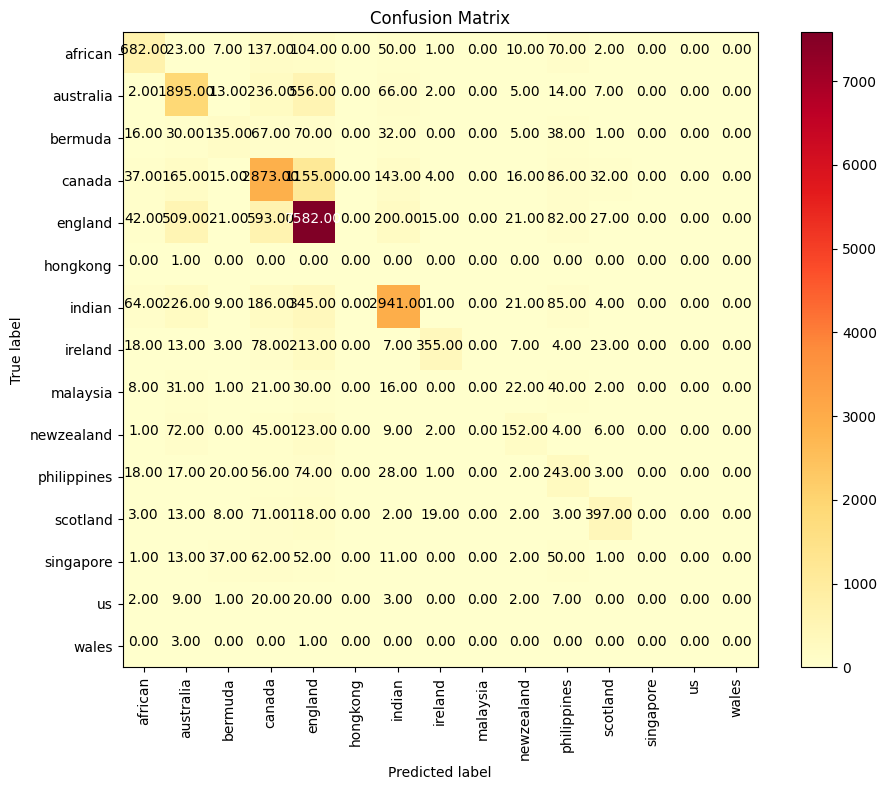

In [ ]:
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, labels_list)

## Saving the model

In [ ]:
model.save_pretrained("/kaggle/working/facebook/wav2vec2-base-960h")
feature_extractor.save_pretrained("/kaggle/working/facebook/wav2vec2-base-960h")

['/kaggle/working/facebook/wav2vec2-base-960h/preprocessor_config.json']

## Loading the ASR model and processor for text prediction

In [ ]:
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC, AutoModelForAudioClassification, AutoFeatureExtractor
import torch

asr_model_name = "facebook/wav2vec2-large-960h-lv60"
asr_processor = Wav2Vec2Processor.from_pretrained(asr_model_name)
asr_model = Wav2Vec2ForCTC.from_pretrained(asr_model_name)

preprocessor_config.json:   0%|          | 0.00/158 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/162 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/841 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-large-960h-lv60 and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Loading the previously saved accent and gender model

In [ ]:
import librosa
from IPython.display import Audio, display

model_path = "/kaggle/working/facebook/wav2vec2-base-960h"
feature_extractor = AutoFeatureExtractor.from_pretrained(model_path)
accent_gender_model = AutoModelForAudioClassification.from_pretrained(model_path)

## Define your id2label for both accent and gender

In [ ]:
accent_id2label = {0: 'african', 1: 'australia', 2: 'bermuda', 3: 'canada', 4: 'england',
                   5: 'hongkong', 6: 'indian', 7: 'ireland', 8: 'malaysia', 9: 'newzealand',
                   10: 'phillipines', 11: 'scotland', 12: 'singapore', 13: 'us', 14: 'wales'}

gender_id2label = {0: 'male', 1: 'female'}

## Define number of labels for accent and gender

In [ ]:
num_accent_labels = len(accent_id2label)
num_gender_labels = len(gender_id2label)

In [ ]:
total_labels = num_accent_labels + num_gender_labels

## Load the ASR model and processor for text prediction

In [ ]:
asr_model_name = "facebook/wav2vec2-large-960h-lv60"
asr_processor = Wav2Vec2Processor.from_pretrained(asr_model_name)
asr_model = Wav2Vec2ForCTC.from_pretrained(asr_model_name)

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-large-960h-lv60 and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import (AutoFeatureExtractor, AutoModelForAudioClassification,
                          TrainingArguments, Trainer, AutoConfig, Wav2Vec2Processor,
                          Wav2Vec2ForCTC)
model_path = "/kaggle/working/facebook/wav2vec2-base-960h"
config = AutoConfig.from_pretrained(model_path, num_labels=total_labels)
accent_gender_model = AutoModelForAudioClassification.from_pretrained(model_path, config=config, ignore_mismatched_sizes=True)
feature_extractor = AutoFeatureExtractor.from_pretrained(model_path)

Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at /kaggle/working/facebook/wav2vec2-base-960h and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([15, 256]) in the checkpoint and torch.Size([17, 256]) in the model instantiated
- classifier.bias: found shape torch.Size([15]) in the checkpoint and torch.Size([17]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def predict_sample(audio_path):
    speech, rate = librosa.load(audio_path, sr=16000)
    display(Audio(speech, rate=rate))
    input_values = asr_processor(speech, return_tensors="pt", sampling_rate=rate, padding=True).input_values
    logits = asr_model(input_values).logits
    predicted_ids = torch.argmax(logits, dim=-1)
    transcription = asr_processor.decode(predicted_ids[0])

    inputs = feature_extractor(speech, sampling_rate=rate, return_tensors="pt", padding=True)
    with torch.no_grad():
        outputs = accent_gender_model(**inputs)

    print(f"Logits shape: {outputs.logits.shape}")

    logits = outputs.logits
    accent_logits = logits[:, :num_accent_labels]
    gender_logits = logits[:, num_accent_labels:num_accent_labels + num_gender_labels]

    print(f"Accent logits shape: {accent_logits.shape}")
    print(f"Gender logits shape: {gender_logits.shape}")

    predicted_accent = torch.argmax(accent_logits, dim=-1).item()
    if gender_logits.shape[1] > 0:
        predicted_gender = torch.argmax(gender_logits, dim=-1).item()
        predicted_gender_label = gender_id2label[predicted_gender]
    else:
        predicted_gender_label = "Unknown"

    predicted_accent_label = accent_id2label[predicted_accent]

    return transcription, predicted_accent_label, predicted_gender_label

audio_path = "/kaggle/input/common-voice/cv-valid-test/cv-valid-test/sample-000000.mp3"
text, accent, gender = predict_sample(audio_path)
print(f"Predicted Text: {text}")
print(f"Predicted Accent: {accent}")
print(f"Predicted Gender: {gender}")

Logits shape: torch.Size([1, 17])
Accent logits shape: torch.Size([1, 15])
Gender logits shape: torch.Size([1, 2])
Predicted Text: WITHOUT THE DATA SET THE ARTICLE IS USELESS
Predicted Accent: singapore
Predicted Gender: female


In [ ]:
def predict_sample(audio_path):
    speech, rate = librosa.load(audio_path, sr=16000)
    display(Audio(speech, rate=rate))
    input_values = asr_processor(speech, return_tensors="pt", sampling_rate=rate, padding=True).input_values
    logits = asr_model(input_values).logits
    predicted_ids = torch.argmax(logits, dim=-1)
    transcription = asr_processor.decode(predicted_ids[0])
    inputs = feature_extractor(speech, sampling_rate=rate, return_tensors="pt", padding=True)
    with torch.no_grad():
        outputs = accent_gender_model(**inputs)
    print(f"Logits shape: {outputs.logits.shape}")

    logits = outputs.logits
    accent_logits = logits[:, :num_accent_labels]
    gender_logits = logits[:, num_accent_labels:num_accent_labels + num_gender_labels]
    print(f"Accent logits shape: {accent_logits.shape}")
    print(f"Gender logits shape: {gender_logits.shape}")
    predicted_accent = torch.argmax(accent_logits, dim=-1).item()
    if gender_logits.shape[1] > 0:
        predicted_gender = torch.argmax(gender_logits, dim=-1).item()
        predicted_gender_label = gender_id2label[predicted_gender]
    else:
        predicted_gender_label = "Unknown"
    predicted_accent_label = accent_id2label[predicted_accent]
    return transcription, predicted_accent_label, predicted_gender_label

audio_path = "/kaggle/input/common-voice/cv-valid-test/cv-valid-test/sample-000019.mp3"
text, accent, gender = predict_sample(audio_path)
print(f"Predicted Text: {text}")
print(f"Predicted Accent: {accent}")
print(f"Predicted Gender: {gender}")

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-large-960h-lv60 and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at /kaggle/working/facebook/wav2vec2-base-960h and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([15, 256]) in the checkpoint and torch.Size([17, 256]) in the model instantiated
- classifier.bias: found shape torch.Size([15]) in the checkpoint and torch.Size([17]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Logits shape: torch.Size([1, 17])
Accent logits shape: torch.Size([1, 15])
Gender logits shape: torch.Size([1, 2])
Predicted Text: IT MUST HAVE FALLEN WHILE I WAS SITTING OVER THERE
Predicted Accent: ireland
Predicted Gender: female


In [ ]:
def predict_sample(audio_path):
    speech, rate = librosa.load(audio_path, sr=16000)
    display(Audio(speech, rate=rate))
    input_values = asr_processor(speech, return_tensors="pt", sampling_rate=rate, padding=True).input_values
    logits = asr_model(input_values).logits
    predicted_ids = torch.argmax(logits, dim=-1)
    transcription = asr_processor.decode(predicted_ids[0])
    inputs = feature_extractor(speech, sampling_rate=rate, return_tensors="pt", padding=True)
    with torch.no_grad():
        outputs = accent_gender_model(**inputs)
    print(f"Logits shape: {outputs.logits.shape}")

    logits = outputs.logits
    accent_logits = logits[:, :num_accent_labels]
    gender_logits = logits[:, num_accent_labels:num_accent_labels + num_gender_labels]
    print(f"Accent logits shape: {accent_logits.shape}")
    print(f"Gender logits shape: {gender_logits.shape}")

    predicted_accent = torch.argmax(accent_logits, dim=-1).item()
    if gender_logits.shape[1] > 0:
        predicted_gender = torch.argmax(gender_logits, dim=-1).item()
        predicted_gender_label = gender_id2label[predicted_gender]
    else:
        predicted_gender_label = "Unknown"
    predicted_accent_label = accent_id2label[predicted_accent]
    return transcription, predicted_accent_label, predicted_gender_label

audio_path = "/kaggle/input/common-voice/cv-valid-test/cv-valid-test/sample-000095.mp3"
text, accent, gender = predict_sample(audio_path)
print(f"Predicted Text: {text}")
print(f"Predicted Accent: {accent}")
print(f"Predicted Gender: {gender}")

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-large-960h-lv60 and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at /kaggle/working/facebook/wav2vec2-base-960h and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([15, 256]) in the checkpoint and torch.Size([17, 256]) in the model instantiated
- classifier.bias: found shape torch.Size([15]) in the checkpoint and torch.Size([17]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Logits shape: torch.Size([1, 17])
Accent logits shape: torch.Size([1, 15])
Gender logits shape: torch.Size([1, 2])
Predicted Text: HE REMEMBERED SOMETHING HIS GRANDFATHER HAD ONCE TOLD HIM THAT BUTTERFLIES WERE A GOOD OMEN
Predicted Accent: newzealand
Predicted Gender: male


In [ ]:
def predict_sample(audio_path):
    speech, rate = librosa.load(audio_path, sr=16000)
    display(Audio(speech, rate=rate))
    input_values = asr_processor(speech, return_tensors="pt", sampling_rate=rate, padding=True).input_values
    logits = asr_model(input_values).logits
    predicted_ids = torch.argmax(logits, dim=-1)
    transcription = asr_processor.decode(predicted_ids[0])
    inputs = feature_extractor(speech, sampling_rate=rate, return_tensors="pt", padding=True)
    with torch.no_grad():
        outputs = accent_gender_model(**inputs)
    print(f"Logits shape: {outputs.logits.shape}")
    logits = outputs.logits
    accent_logits = logits[:, :num_accent_labels]
    gender_logits = logits[:, num_accent_labels:num_accent_labels + num_gender_labels]
    print(f"Accent logits shape: {accent_logits.shape}")
    print(f"Gender logits shape: {gender_logits.shape}")

    predicted_accent = torch.argmax(accent_logits, dim=-1).item()
    if gender_logits.shape[1] > 0:
        predicted_gender = torch.argmax(gender_logits, dim=-1).item()
        predicted_gender_label = gender_id2label[predicted_gender]
    else:
        predicted_gender_label = "Unknown"

    predicted_accent_label = accent_id2label[predicted_accent]

    return transcription, predicted_accent_label, predicted_gender_label

audio_path = "/kaggle/input/common-voice/cv-valid-test/cv-valid-test/sample-000010.mp3"
text, accent, gender = predict_sample(audio_path)
print(f"Predicted Text: {text}")
print(f"Predicted Accent: {accent}")
print(f"Predicted Gender: {gender}")

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-large-960h-lv60 and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at /kaggle/working/facebook/wav2vec2-base-960h and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([15, 256]) in the checkpoint and torch.Size([17, 256]) in the model instantiated
- classifier.bias: found shape torch.Size([15]) in the checkpoint and torch.Size([17]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Logits shape: torch.Size([1, 17])
Accent logits shape: torch.Size([1, 15])
Gender logits shape: torch.Size([1, 2])
Predicted Text: YOUR SON WENT TO SERVE AT A DISTANT PLACE AND BECAME A CENTURIAN
Predicted Accent: hongkong
Predicted Gender: female


In [ ]:
def predict_sample(audio_path):
    speech, rate = librosa.load(audio_path, sr=16000)
    display(Audio(speech, rate=rate))
    input_values = asr_processor(speech, return_tensors="pt", sampling_rate=rate, padding=True).input_values
    logits = asr_model(input_values).logits
    predicted_ids = torch.argmax(logits, dim=-1)
    transcription = asr_processor.decode(predicted_ids[0])
    inputs = feature_extractor(speech, sampling_rate=rate, return_tensors="pt", padding=True)
    with torch.no_grad():
        outputs = accent_gender_model(**inputs)
    print(f"Logits shape: {outputs.logits.shape}")

    logits = outputs.logits
    accent_logits = logits[:, :num_accent_labels]
    gender_logits = logits[:, num_accent_labels:num_accent_labels + num_gender_labels]
    print(f"Accent logits shape: {accent_logits.shape}")
    print(f"Gender logits shape: {gender_logits.shape}")
    predicted_accent = torch.argmax(accent_logits, dim=-1).item()
    if gender_logits.shape[1] > 0:
        predicted_gender = torch.argmax(gender_logits, dim=-1).item()
        predicted_gender_label = gender_id2label[predicted_gender]
    else:
        predicted_gender_label = "Unknown"
    predicted_accent_label = accent_id2label[predicted_accent]
    return transcription, predicted_accent_label, predicted_gender_label

audio_path = "/kaggle/input/common-voice/cv-valid-train/cv-valid-train/sample-068237.mp3"
text, accent, gender = predict_sample(audio_path)
print(f"Predicted Text: {text}")
print(f"Predicted Accent: {accent}")
print(f"Predicted Gender: {gender}")

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-large-960h-lv60 and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at /kaggle/working/facebook/wav2vec2-base-960h and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([15, 256]) in the checkpoint and torch.Size([17, 256]) in the model instantiated
- classifier.bias: found shape torch.Size([15]) in the checkpoint and torch.Size([17]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Logits shape: torch.Size([1, 17])
Accent logits shape: torch.Size([1, 15])
Gender logits shape: torch.Size([1, 2])
Predicted Text: COME INTO THE OFFICE A MINUTE
Predicted Accent: indian
Predicted Gender: female
